In [1]:
import os
os.environ['R_HOME'] = '/root/miniconda/envs/stVAT/lib/R' 
import rpy2.robjects as ro
ro.r('R.version')

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 


<rpy2.robjects.vectors.ListVector object at 0x7f28ac212580> [RTYPES.VECSXP]
R classes: ('simple.list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1aa940> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64-conda-linux-gnu']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1aacc0> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1aafc0> [RTYPES.STRSXP]
R classes: ('character',)
['linux-gnu']
  system: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1af300> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64, linux-gnu']
...
  major: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1af640> [RTYPES.STRSXP]
R classes: ('character',)
['83980']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1af940> [RTYPES.STRSXP]
R classes: ('character',)
['R']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28ac1aaac0> [RTYPES.STRSXP]
R classes: ('character',)
['R version 4.2.3 (2023-03-15)']
  month: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f28db663dc0> [RTYPES.STRSXP]
R classes: ('character',)
['Shortstop Beagle']

In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import os 
import warnings 
warnings.filterwarnings("ignore") 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import PROST 
# Set seed
SEED = 818
PROST.setup_seed(SEED)

In [3]:
import anndata as ad
counts_file = '/root/IDC/IDCimpute.csv'
coords_file = '/root/IDC/IDCimputed_spatial_positions.csv'
counts_df = pd.read_csv(counts_file, index_col=0)
coords_df = pd.read_csv(coords_file, index_col=0)
grid_size = 0.5
coords_df = np.floor(coords_df/ grid_size).astype(int)
# Create AnnData object
adata = sc.AnnData(counts_df)
# Set the coordinates as spatial information
adata.obsm['spatial'] = coords_df.values
# If you have gene names in the CSV, make sure they are set as row names
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 18617 × 17849
    obsm: 'spatial'


In [4]:
locates = adata.obsm['spatial']

In [5]:
if not counts_df.empty:
    adata.obs['array_col'] = coords_df.iloc[:, 0].values  
    adata.obs['array_row'] = coords_df.iloc[:, 1].values 
    adata.obs['image_idx_1d'] = adata.obs['array_col'] + adata.obs['array_row']
    print(adata.obs[['array_col', 'array_row', 'image_idx_1d']].head())
else:
    print("imputed_spatial_df is empty.")

                    array_col  array_row  image_idx_1d
GTGGGTCTTCTTTGCG-1          4         36            40
2x19                        4         38            42
GCTACACTGTCCGAAC-1          4         40            44
2x21                        4         42            46
CCTAAGTGTCTAACCG-1          4         44            48


In [6]:
adata = PROST.prepare_for_PI(adata, percentage = 0.01, platform="visium")


Filtering genes ...

Calculating image index 1D:


100%|██████████| 18617/18617 [00:00<00:00, 29382.83it/s]


In [7]:
adata = PROST.cal_PI(adata,  platform="visium",multiprocess=True)


Normalize each geneing...

Gaussian filtering...


100%|██████████| 17849/17849 [00:37<00:00, 472.48it/s]



Binary segmentation for each gene:


100%|██████████| 17849/17849 [00:43<00:00, 407.29it/s]



Spliting subregions for each gene:


100%|██████████| 17849/17849 [14:30<00:00, 20.50it/s]



Computing PROST Index for each gene:


100%|██████████| 17849/17849 [00:37<00:00, 471.43it/s]



PROST Index calculation completed !!


In [8]:
import os
output_dir = '/root/datasets/IDC/results'
if not os.path.exists(output_dir):
    print(f"Directory {output_dir} does not exist.")
os.makedirs(output_dir, exist_ok=True)

In [9]:
adata.write_h5ad(output_dir+"/PI_result.h5")

In [10]:
adata = sc.read(output_dir+"/PI_result.h5")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata = PROST.feature_selection(adata, by = "prost",n_top_genes = 3000)

In [11]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.4.1+cu121
12.1


In [12]:
PROST.run_PNN(adata,
            key_added = "PROST",
            init="mclust",                         
            n_clusters = 9,  
            adj_mode = "neighbour",
            k_neighbors = 12, 
            lap_filter=2,                                  
            lr = 0.005,                         
            SEED=SEED,                          
            max_epochs = 500,                        
            tol = 0.005,                        
            post_processing = True,                        
            pp_run_times = 2,
            cuda = True)


Calculating adjacency matrix, mode=neighbour, k_neighbors=12...

Running PCA ...
Laplacian Smoothing ...
Using cuda acceleration


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.




Initializing cluster centers with mclust, n_clusters known
fitting ...
  |======================================================================| 100%


Epoch: : 501it [00:30, 16.22it/s, loss=0.15991805]                       


Clustering completed !!

Post-processing for clustering result ...
Refining clusters, run times: 1/2
Refining clusters, run times: 2/2


AnnData object with n_obs × n_vars = 18617 × 3000
    obs: 'array_col', 'array_row', 'image_idx_1d', 'clustering', 'pp_clustering'
    var: 'n_cells', 'SEP', 'SIG', 'PI', 'selected'
    uns: 'binary_image', 'del_index', 'gau_fea', 'grid_size', 'locates', 'nor_counts', 'subregions', 'log1p'
    obsm: 'spatial', 'PROST'

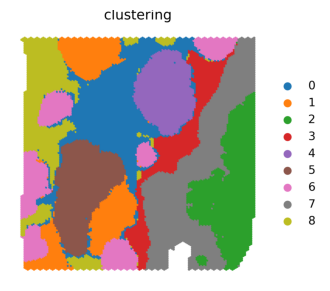

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import scanpy as sc
color_list = plt.cm.tab20.colors
adata.uns['scatter_plot_params'] = {"size": 800} 
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots()
sc.pl.embedding(adata, basis="spatial", color="clustering", size=600, s=20, ax=ax,  # 调整散点
                show=False)
ax.axis('off')
from io import BytesIO
buffer = BytesIO()
plt.savefig(buffer, format='PNG', dpi=600, bbox_inches='tight', pad_inches=0)
buffer.seek(0)
plt.close(fig)
image = Image.open(buffer)
plt.imshow(image)
plt.axis('off') 
plt.show()


In [14]:
#Output the clustering labels, and remember to mark the original coordinate positions.
cluster_labels = adata.obs['clustering']
cluster_labels.to_csv('/root/datasets/IDC/results/cluster_labels.csv', index=True)

In [15]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score
goldtruth_df = pd.read_csv("/root/PROST/idcARItruthN=12.csv")
predicted_df = pd.read_csv("/root/PROST/cluster_labels.csv")
print("Gold truth columns:", goldtruth_df.columns)
print("Predicted columns:", predicted_df.columns)
# Merge the two dataframes on the cell identifier (array_row, array_col)
merged_df = pd.merge(goldtruth_df, predicted_df, on=["array_row", "array_col"], suffixes=('_goldtruth', '_predicted'))
true_labels = merged_df['label_goldtruth']
predicted_labels = merged_df['label_predicted']
# Calculate the Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Gold truth columns: Index(['Unnamed: 0.1', 'Unnamed: 0', 'array_row', 'array_col', 'label'], dtype='object')
Predicted columns: Index(['cell_id', 'array_row', 'array_col', 'label'], dtype='object')
Adjusted Rand Index (ARI): 0.8502


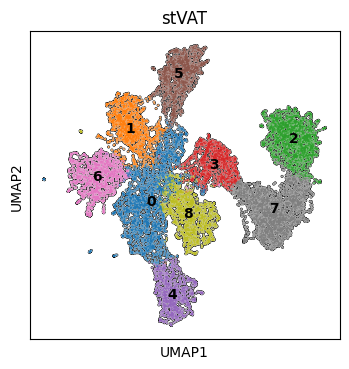

In [16]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
prost_embed = pd.read_csv(output_dir + "/embedding.txt", header=None, delim_whitespace=True)
adata.obsm["PROST"] = prost_embed.values
sc.pp.neighbors(adata, use_rep="PROST")
sc.tl.umap(adata)
sc.tl.paga(adata, groups='clustering')
sc.pl.umap(adata, color='clustering', add_outline=True, show=False, legend_loc='on data', title='stVAT')
plt.show()

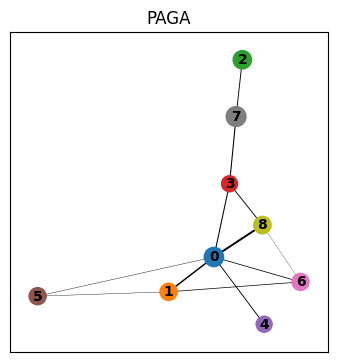

In [17]:
import scanpy as sc
import matplotlib.pyplot as plt
ax = sc.pl.paga(adata, title="PAGA", show=False)
fig = ax.get_figure()
fig.set_size_inches(4, 4)
plt.show()

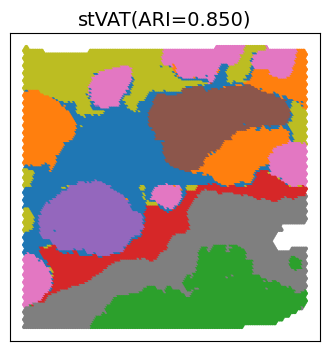

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
clusters = adata.obs['clustering'] 
cluster_colors = adata.uns['clustering_colors']  
filled_data = pd.DataFrame({
    'array_col': adata.obsm['spatial'][:, 0],
    'array_row': adata.obsm['spatial'][:, 1],
    'lable': clusters
})
filled_data['array_col'], filled_data['array_row'] = filled_data['array_row'], -filled_data['array_col']
filled_data['array_col'] = -filled_data['array_col']
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x='array_col', 
    y='array_row', 
    hue='lable', 
    data=filled_data, 
    palette=cluster_colors,  
    s=9, 
    edgecolor='none'
)

plt.title('stVAT(ARI=0.850)', fontsize=14)
plt.xlabel('') 
plt.ylabel('')  
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.legend([], [], frameon=False)
plt.show()